# Nonlinear Modeling

revision: dcfbda7

In [67]:
# @formatter:off
# PREAMBLE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import check_grad
from scipy.optimize import minimize
from functools import partial
from mlis.arrays import aslabel, asinput

%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
%load_ext autoreload
%autoreload 2
# @formatter:on

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


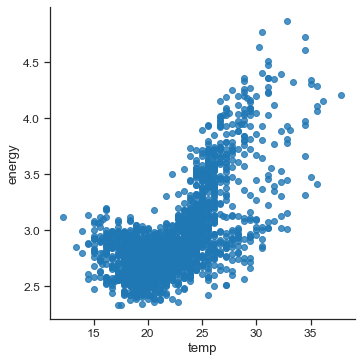

In [68]:
# load the data
df = pd.read_csv('energy.csv', sep=' ')
sns.lmplot(x='temp', y='energy', data=df, fit_reg=False)

In order to do better, we need a way to expressing the nonlinear relationship between the inputs and outputs.
The python function `poly_feat` maps a given input to a polynomial of a certain degree. For example
$$
\text{temperature} \mapsto \begin{bmatrix}1 \\ \text{temperature} \\ \text{temperature}^2\end{bmatrix}
$$
if degree is equal to 2.

In [69]:
# Open features.py and implement the function poly_feat
from mlis.nonlinear.features import poly_feat

# use dummy data
X = asinput([1, 2, -1])
# test shape
np.testing.assert_array_equal(poly_feat(X, 3).shape, (3, 4))
# test first entry
expected = np.array([[1., 1., 1., 1.],
                     [1., 2., 4., 8.],
                     [1., -1., 1., -1.]])
np.testing.assert_array_almost_equal(poly_feat(X, 3), expected, decimal=3)

Write a function `ls_poly` which learns a model $h$ with the closed-form least squares algorithm.

1. Project the inputs into a polynomial feature space using the `poly_feat` function (this is our $\phi$).
2. Determine the optimal weights $w = \big(\phi(X)^T\phi(X) \big)^{-1}\phi(X)^Ty$.
3. Return a *function* $h\colon X \mapsto w^{T}\phi(X)$

In [70]:
# Open nonlinear_regression.py and implement the function ls_poly

from mlis.nonlinear.nonlinear_regression import ls_poly

X = asinput([1, 2, 4, 5, 6, 7])
y = aslabel([1, 2 ** 3, 4 ** 3, 5 ** 3, 6 ** 3, 7 ** 3])
h = ls_poly(X, y, degree=3)

np.testing.assert_array_almost_equal(h(asinput([1, 2])), [1, 8], decimal=3)

We now perform regression with polynomials of different degrees. This should reproduce the plots in figure 4.4 on page 29

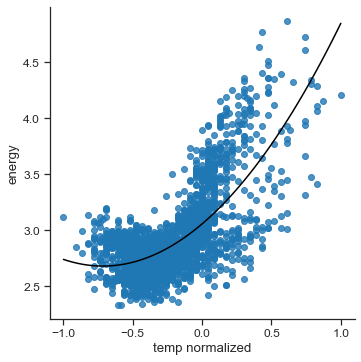

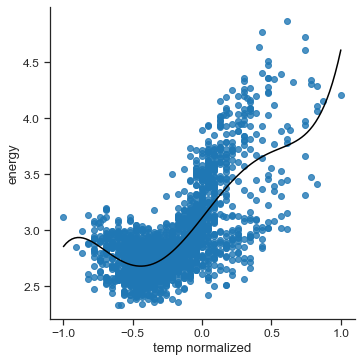

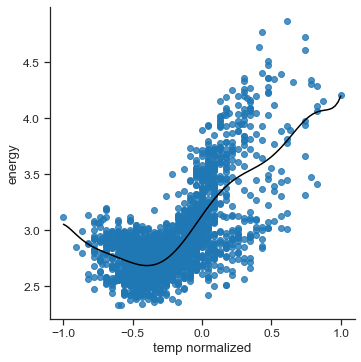

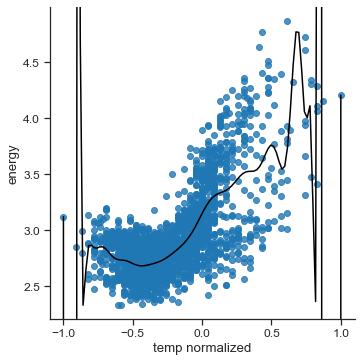

In [71]:
def plot_fit(h):
    x = np.linspace(df['temp normalized'].min(), df['temp normalized'].max(), 100)
    y = np.squeeze(h(x))
    sns.lmplot(x='temp normalized', y='energy', data=df, fit_reg=False)
    ylim = plt.ylim()
    plt.plot(x, y, 'k', label='Prediction')
    plt.ylim(ylim)


# with polynomials features is best to work with data between -1 and 1.
df['temp normalized'] = 2 * (df['temp'] - df['temp'].min()) / (df['temp'].max() - df['temp'].min()) - 1

# load the data
X = df['temp normalized'].values
y = df['energy'].values

# plot the linear regression with different polynomial degrees
for degree in [2, 5, 9, 100]:
    plot_fit(ls_poly(X, y, degree=degree))

# Cross Validation

The simplest of these techniques is the *holdout set* method.
Here we randomly split our data into two groups, the new *training set* and the *holdout* or *validation set*.

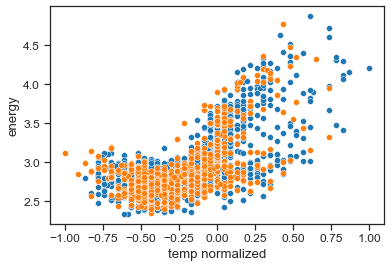

In [72]:
def split(df, fraction, rng):
    """
    given a dataframe df, split it into `fraction` training and `1-fraction` cv instances.
    """
    # get a list of indices and permute them
    perm = rng.permutation(len(df))
    # create indices for train and cv splits
    idx_train = perm[:int(len(perm) * fraction)]
    idx_cv = perm[int(len(perm) * fraction):]
    # return actual data
    train = df.iloc[idx_train]
    cv = df.iloc[idx_cv]
    return train, cv


# always seed your random number generator to have reproducible results
rng = np.random.RandomState(5)
train, cv = split(df, 0.7, rng)

# plot splits
fig, ax = plt.subplots()
sns.scatterplot(ax=ax, x='temp normalized', y='energy', data=train)
sns.scatterplot(ax=ax, x='temp normalized', y='energy', data=cv);

Reproduce the "polynomial degree vs. mean squared error" plots in figure 4.8 on page 32
Use a function which calculates the mean squared error on the training set `train` and on the validation set `cv` depending on the polynomial degree.

In [73]:
# insert your code here

from sklearn.metrics import mean_squared_error

degrees = range(30)
X_train = train["temp normalized"]
y_train = train["energy"]
X_val = cv["temp normalized"]
y_val = cv["energy"]

err_train = []
err_cv = []
for deg in degrees:
    h = ls_poly(X_train, y_train, deg)
    err_train.append(mean_squared_error(y_train, h(X_train)))
    err_cv.append(mean_squared_error(y_val, h(X_val)))

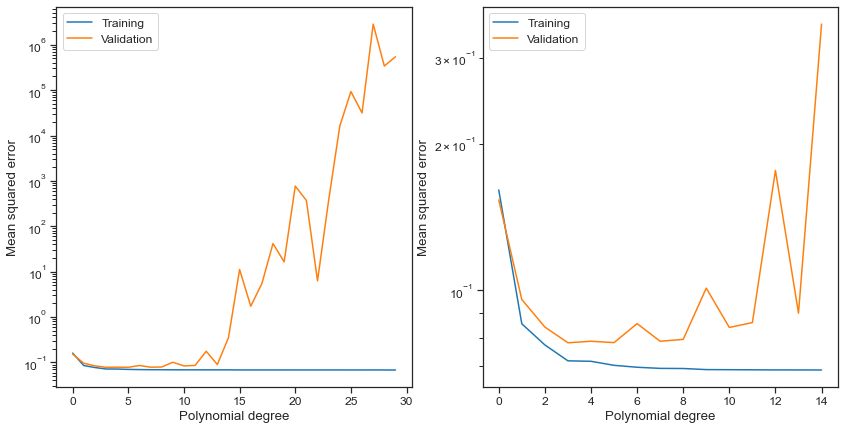

In [74]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.semilogy(degrees, err_train, degrees, err_cv)
ax1.legend(["Training", "Validation"])
ax1.set_xlabel("Polynomial degree")
ax1.set_ylabel("Mean squared error")

ax2.semilogy(degrees[:15], err_train[:15], degrees[:15], err_cv[:15])
ax2.legend(["Training", "Validation"])
ax2.set_xlabel("Polynomial degree")
ax2.set_ylabel("Mean squared error");

# Regularization

For far, we used the degree of the polynomial feature function as a tool to control model complexity.
Recall, that the degree 100 polynomial overfits the peak demand data since it tries to pass through many of the data points with the aim to minimizing the objective function.

Plot the absolute weights/values of the polynomial coefficients of a degree 100 polynomial fitted to the peak d data.
This should reproduce figure 4.15 on page 38

In [75]:
# load the data
X = df['temp normalized'].values
y = df['energy'].values

# insert your code here
phi = poly_feat(X, 100)
w = np.linalg.solve(phi.T @ phi, phi.T @ y)

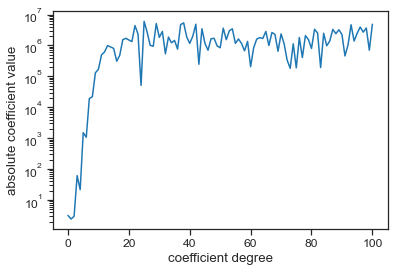

In [76]:
plt.semilogy(range(101), np.abs(w))
plt.xlabel('coefficient degree');
plt.ylabel('absolute coefficient value');

Implement the closed form solution of ridge regression to obtain the optimal parameters.
Use $\lambda=8.0$ and a polynomial degree of $100$.

In [77]:
# insert your code here
lam = 8.
degree = 100
phi = poly_feat(X, degree)
w_ridge = np.linalg.solve(phi.T @ phi + lam*np.eye(degree+1), phi.T @ y)

Plot the coefficient weights of the regularized and unregularized weights.
This should reproduce figure 4.17 on page 40.

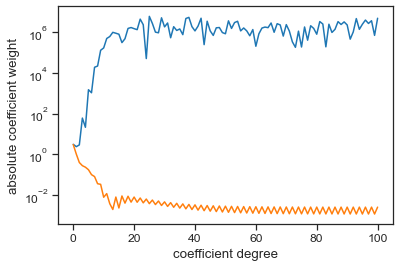

In [78]:
plt.semilogy(range(101), np.abs(w), range(101), np.abs(w_ridge))
plt.xlabel('coefficient degree');
plt.ylabel('absolute coefficient weight');

### Ridge Regression

Implement polynomial ridge regression in the function `ridge_poly`.

1. Project the the inputs into a polynomial feature space using the `poly_feat` function (this is our $\phi$).
2. Determine the optimal weights $w = \big(\phi(X)^T\phi(X) + \lambda I\big)^{-1}\phi(X)^Ty$.
3. Return a *function* $h\colon X \mapsto w^{T}\phi(X)$

In [79]:
# Open nonlinear_regression.py and implement the function ridge_poly

from mlis.nonlinear.nonlinear_regression import ridge_poly

X = asinput([1, 2, 4, 5, 6, 7])
y = aslabel([1, 2 ** 3, 4 ** 3, 5 ** 3, 6 ** 3, 7 ** 3])
h = ridge_poly(X, y, degree=3, lam=1e6)

np.testing.assert_array_almost_equal(h(asinput([1, 2])), [0.184, 1.344], decimal=3)

Reproduce the "$\lambda$ vs. mean squared error" plot figure 4.18 on page 40.
Use a function which calculates the mean squared error on the training set `train` and on the validation set `cv` depending on $\lambda$.
The polynomial degree is fixed to $100$.

In [80]:
# insert your code here

from sklearn.metrics import mean_squared_error

lambdas = np.logspace(-15, 10, 100)
degree = 100
X_train = train["temp normalized"]
y_train = train["energy"]
X_val = cv["temp normalized"]
y_val = cv["energy"]

err_train = []
err_cv = []
for lam in lambdas:
    h = ridge_poly(X_train, y_train, degree, lam)
    err_train.append(mean_squared_error(y_train, h(X_train)))
    err_cv.append(mean_squared_error(y_val, h(X_val)))

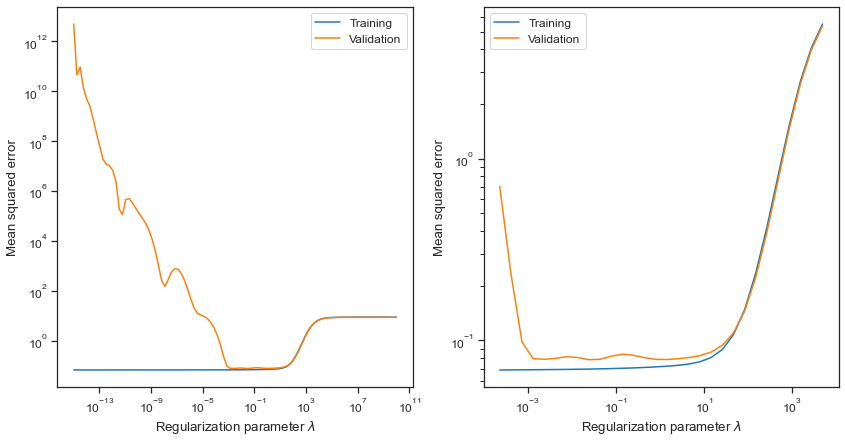

In [81]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
ax1.loglog(lambdas, err_train, lambdas, err_cv)
ax1.legend(["Training", "Validation"])
ax1.set_xlabel("Regularization parameter $\lambda$")
ax1.set_ylabel("Mean squared error")

ax2.loglog(lambdas[45:75], err_train[45:75], lambdas[45:75], err_cv[45:75])
ax2.legend(["Training", "Validation"])
ax2.set_xlabel("Regularization parameter $\lambda$")
ax2.set_ylabel("Mean squared error");

# Lasso Regression

Similar to ridge regression, there’s another regularized regression technique called \define{lasso regression} which uses $\ell_1$-regularization, ie $\Omega(w) = \sum_{i=1}^{n} |w_i| = ||{w}||_1$.
The only difference is that we are taking the absolute value instead of the square of all
the weights.

Implement $J$ and $\nabla J$ for Lasso regression.

In [82]:
# Open lasso_regression.py and implement the functions J and dJ

from mlis.nonlinear.lasso_regression import J, dJ

X = asinput([1, 2, 4, 5, 6, 7])
y = aslabel([1, 2 ** 3, 4 ** 3, 5 ** 3, 6 ** 3, 7 ** 3])
w = [-0.008, -0.02, 0.02, 1]
degree = 3
lam = 8

np.testing.assert_array_almost_equal(J(w, X, y, degree, lam), 8.59, decimal=2)
np.testing.assert_almost_equal(check_grad(J, dJ, w, X, y, degree, lam), 0.0, decimal=3)

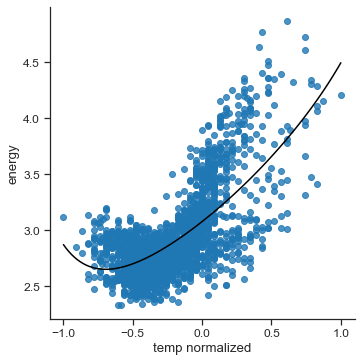

In [83]:
# load the data
X = df['temp normalized'].values
y = df['energy'].values
lam = 7 / X.shape[0]
degree = 100

# we do not implement gradient descent again, but use scipy.optimize
# have a look at the documentation of this function to understand what we are doing here.
w_lasso = minimize(J, np.zeros((degree + 1,)), args=(X, y, degree, lam), jac=dJ, method='CG').x
h = lambda X: np.dot(poly_feat(X, degree), w_lasso.T)

plot_fit(h)

Reproduce figure 4.19 on page 41

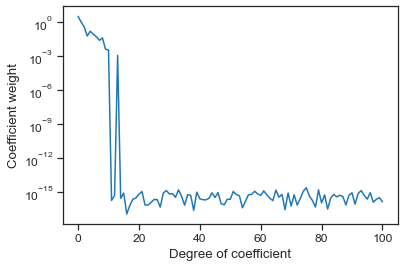

In [84]:
# plot the lasso weights. Make sure that most of them are (close to) zero.
plt.figure()
plt.semilogy(np.abs(w_lasso))
plt.xlabel("Degree of coefficient")
plt.ylabel("Coefficient weight");